In [1]:
%matplotlib inline
import sys
sys.path.append("/home/diego/Dropbox/hold_noise/iclamp-glm/")

%load_ext autoreload
%autoreload 2

Starting gradient ascent... 

 Iteration 24 of 100 | Elapsed time: 0.06 seconds | log_prior=nan | log_posterior=-313.53
 
 Iteration 24 of 100 | Converged | Elapsed time: 0.001 minutes | Log posterior is monotonic 

Starting gradient ascent... 

 Iteration 38 of 100 | Elapsed time: 1.02 seconds | log_prior=nan | log_posterior=-343.41
 
 Iteration 38 of 100 | Converged | Elapsed time: 0.0171 minutes | Log posterior is monotonic 



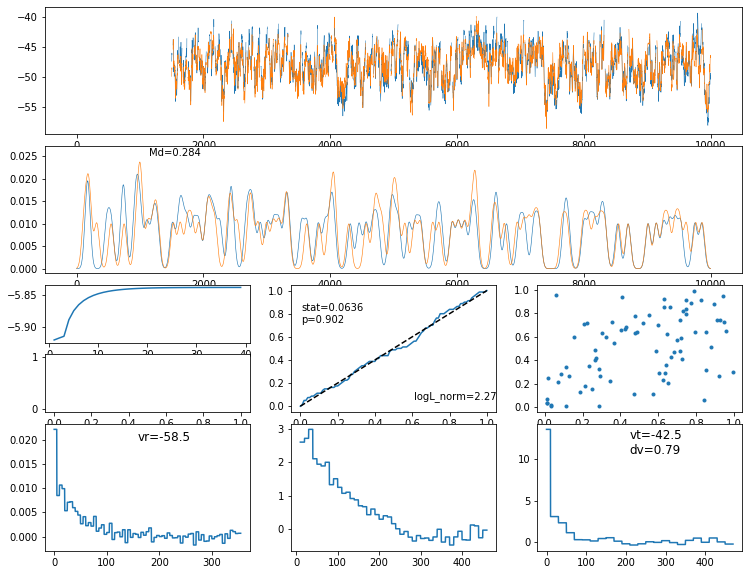

In [2]:
import numpy as np
# from icglm.glm_fitting import GLMFitter
from icglm.iclamp import IClamp
from icglm.kernels import KernelFun, KernelRect
from icglm.models.lssrm import LSSRM
from icglm.models.vglm import VGLM
from icglm.plot.fit import SRMPlotter
from icglm.spiketrain import SpikeTrain

ic = IClamp.load_from_abf(path='./18o03049.abf')
ic = ic.sweeps(np.array([0]))
# t0, tf = 0, 12000.2
t0, tf = 1000.1, 11000.1
ic = ic.subtract_Ih(th=1000.1).restrict(t0=t0, tf=tf, reset_time=True)
ic = ic.set_mask_spikes(thr=-13, t_before_spike_peak=0.8).subsample(1)
mask_subthreshold = ic.get_mask_away_from_spikes(5, 10, t0=1500)

kappa = KernelRect(tbins=np.arange(0, 360, 5))
eta = KernelRect(tbins=np.arange(10, 470, 10))
tbins_gamma = np.append([0], np.arange(10, 480, 20))
coefs_gamma0 = 5 * np.exp(-tbins_gamma[:-1] / 50)
gamma = KernelRect(tbins=tbins_gamma, coefs=coefs_gamma0)

newton_kwargs = dict(max_iterations=100, stop_cond=5e-4, learning_rate=1e-1, initial_learning_rate=1e-2, warm_up_iterations=2)
lssrm = LSSRM(vr=-65, kappa=kappa.copy(), eta=eta.copy(), vt=-35, dv=1, gamma=gamma.copy())
optimizer, logl = lssrm.fit(ic.t, ic.stim, ic.mask_spikes, ic.v, mask_subthreshold, newton_kwargs=newton_kwargs, verbose=True)

newton_kwargs = dict(max_iterations=100, stop_cond=5e-6, learning_rate=1e-1, initial_learning_rate=1e-2, warm_up_iterations=2)
lam = 1e-2
vglm = VGLM(vr=lssrm.vr, kappa=lssrm.kappa.copy(), eta=lssrm.eta.copy(), vt=lssrm.vt, dv=lssrm.dv, gamma=lssrm.gamma.copy(), lam=lam)
newton_kwargs['stop_cond'] = newton_kwargs['stop_cond'] * (1 - lam)
optimizer, logl = vglm.fit(ic.t, ic.stim, ic.mask_spikes, ic.v, mask_subthreshold, newton_kwargs=newton_kwargs, verbose=True)

z, ks_stats = vglm.time_rescale_transform(ic.t, ic.stim, ic.mask_spikes)
v_model, r = vglm.simulate_subthreshold(ic.t, ic.stim, ic.mask_spikes)
_, _, mask_spikes_model = vglm.sample(ic.t, ic.stim)

kernel1, kernel2 = KernelRect.kistler_kernels(4, 1)
psth_kernel = KernelFun.gaussian_delta(delta=40)
st_exp = SpikeTrain(ic.t, ic.mask_spikes)
st_model = SpikeTrain(ic.t, mask_spikes_model)
psth_exp = st_exp.get_psth(psth_kernel)
psth_model = st_model.get_psth(psth_kernel)
Md = st_exp.Md(st_model, kernel1, kernel2)

srmp = SRMPlotter(ic=ic, srm=vglm, mask_subthreshold=mask_subthreshold, optimizer=optimizer, log_likelihood_normed=logl, z=z, ks_stats=ks_stats, 
                  psth_exp=psth_exp, psth_model=psth_model, Md=Md, v_exp=ic.data, v_model=v_model)

fig, axs = srmp.plot_summary()

In [4]:
vglm.get_log_likelihood(ic.t, ic.stim, ic.mask_spikes)

-55.875457954070065